In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy.io import loadmat 

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)

In [2]:
import networkx as nx

from scipy.stats import bernoulli
from scipy.special import loggamma

from sklearn.preprocessing import OneHotEncoder

import tqdm

from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

In [3]:
import os
import glob
import pickle

In [4]:
from oct2py import octave

In [5]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore', UserWarning)

In [6]:
# R packages
## label.switching
label_switching = importr("label.switching")
## base
base = importr("base")

dollar = base.__dict__["$"]

In [7]:
pd.options.display.max_rows = 1000

In [8]:
from functools import lru_cache

@lru_cache(maxsize = 10000)
def normterm_discrete(n, k):
    if n == 1:
        return np.log(k)
    if k == 1:
        return 1.0
    elif k == 2:
        return np.sum(sorted([ np.exp(loggamma(n+1) - loggamma(t+1) - loggamma(n-t+1) + 
                               t*(np.log(t) - np.log(n)) + (n-t)*(np.log(n-t) - np.log(n))
                        )
                        for t in range(1, n)]))
    else:
        return normterm_discrete(n, k-1) + n/(k-2) * normterm_discrete(n, k-2)

In [9]:
def check_latent_index_variable(z):
    unique_z = sorted(np.unique(z))
    if len(unique_z) == np.max(z) + 1:
        return z
    new_z = np.zeros(z.shape, dtype=np.int)
    for index, current in enumerate(unique_z):
        new_z[z == current] = index
    return new_z

In [10]:
def calc_dnml(X, Z1, Z2, K=3, L=3):    
    N = X.shape[0]
    
    codelen_x_z = 0.0
    codelen_z = 0.0

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                codelen_x_z += n_all * np.log(n_all)
                codelen_x_z += np.log(normterm_discrete(n_all, 2))
            
            if n_pos >=2:
                codelen_x_z -= n_pos * np.log(n_pos)
            if n_neg >=2:
                codelen_x_z -= n_neg * np.log(n_neg)
            
        n_k = np.sum(Z1 == k)
        if n_k >= 1:
            codelen_z += n_k * (np.log(N) - np.log(n_k))

    codelen_z += np.log(normterm_discrete(N, K))
    
    codelen = codelen_x_z + codelen_z
    
    return codelen, codelen_x_z, codelen_z

In [11]:
def calc_dnml_by_prob_bernoulli(X, Z, alpha, theta, K=3, L=3):    
    N = X.shape[0]
    
    Z1 = np.argmax(Z, axis=1)
    
    Z1 = check_latent_index_variable(Z1)
    Z2 = Z1
    
    codelen_x_z = 0.0
    codelen_z = 0.0
        
    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg
            
            codelen_x_z += -n_pos * np.ma.log(theta[k, l]) - n_neg * np.ma.log(1.0 - theta[k, l])
            if n_all >=2:
                codelen_x_z += np.log(normterm_discrete(n_all, 2))
    
        n_k = np.sum(Z1 == k)
        codelen_z += -n_k * np.log(alpha[k])

    codelen_z += np.log(normterm_discrete(N, K))

    codelen = codelen_x_z + codelen_z

    return codelen, codelen_x_z, codelen_z

In [13]:
def calc_nml_by_prob_poisson(X, Z, alpha, theta, K=3, L=3, lambda_max=1000, eps=1e-6):    
    N = X.shape[0]
    
    Z1 = np.argmax(Z, axis=1)
    
    Z1 = check_latent_index_variable(Z1)
    Z2 = Z1
    
    codelen = 0.0
    
    K = L = len(np.unique(Z1))
        
    for k in range(K):
        for l in range(L):
            X_sum = np.sum(X[Z1 == k, :][:, Z2 == l])
            n = np.sum(Z1 == k) * np.sum(Z2 == l)
            X_loggamma = np.sum(loggamma(X[Z1 == k, :][:, Z2 == l].ravel() + 1))
            
            #codelen_x_z += -X_sum * np.ma.log(theta[k, l]) + n * theta[k, l] - X_loggamma
            codelen += -X_sum * np.ma.log(theta[k, l]) + n * theta[k, l] + X_loggamma
            #codelen_x_z += -X_sum * np.ma.log(theta[k, l]) + X_sum * theta[k, l] - X_loggamma
            #codelen_x_z += 0.5 * np.log(1.0/(2.0*np.pi)) + (1.0 + lambda_max/2.0) * np.log(2.0) + codelen_integer(lambda_max)
            #codelen_x_z += 0.5 * np.log(n/(2.0*np.pi)) + (1.0 + lambda_max/2.0) * np.log(2.0) + codelen_integer(lambda_max)
            
        n_k = np.sum(Z1 == k)
        codelen += -n_k * np.log(alpha[k])

    codelen += (K-1 + K*(K+1))/2 * np.log(N**2) - (K-1 + K*(K+1)/2) * np.log(np.pi) - \
                K/2 * np.log(2.0) + K * loggamma((K+2)/2 + 1) - loggamma(K*(K+2)/2 + 1) + \
                K*(K+1)/2 * np.log(np.pi)
        
    return codelen

In [14]:
def calc_sc(X, Z1, Z2, K=3, L=3):    
    N = X.shape[0]
    
    sc_x_z = 0.0
    sc_z = 0.0

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                sc_x_z += np.log(normterm_discrete(n_all, 2))

    sc_z += np.log(normterm_discrete(N, K))
    
    return sc_x_z, sc_z

In [15]:
def calc_lsc(X, Z1, Z2, K=3, L=3):    
    codelen = 0.0
    N = X.shape[0]

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                codelen += n_all * np.log(n_all)
            
            if n_pos >=2:
                codelen -= n_pos * np.log(n_pos)
            if n_neg >=2:
                codelen -= n_neg * np.log(n_neg)

        n_k = np.sum(Z1 == k)
        if n_k >= 1:
            codelen += n_k * (np.log(N) - np.log(n_k))

        codelen += (k + (k+1)*(k+2))/2 * np.log(N/(2.0*np.pi)) -(k+1)/2 * np.log(2.0) + \
           (k+1) * loggamma((k+3)/2) - loggamma((k+1)*(k+3)/2) + (k+1)*(k+2)/2 * np.log(np.pi)

    return codelen

In [16]:
def calc_stats(X, z, 
               scores, scores_f, scores_l, h, delta, K=10):
    scores = np.array(scores)
    scores_f = np.array(scores_f)
    scores_l = np.array(scores_l)
    
    T = scores.shape[0] + 2*h
    K = scores.shape[1]
    
    codelens = np.array([ codelen_integer(k) for k in range(1, K+1)])
    
    idxes_all = np.nanargmin(scores + codelens, axis=1)
    
    idxes_all = np.hstack((np.nan * np.ones(h), 
                           idxes_all, 
                           np.nan * np.ones(h)))
    
    models_estimated = np.nan * np.ones(T, dtype=np.float)
    models_former = np.nan * np.ones(T, dtype=np.float)
    models_latter = np.nan * np.ones(T, dtype=np.float)
    stats_complete = np.nan * np.ones(T, dtype=np.float)
    
    n_change = 0  # number of changes so far.
    for t in range(h, T-h):
        alpha= (n_change+1/2) / (t+1+1)
        m_estimated = int(idxes_all[t])

        # estimated blocks
        z_t = np.argmax(z[t][m_estimated], axis=1)

        # stochastic complexity
        sc_x_z, sc_z = calc_sc(X[t, :, :], z_t, z_t, m_estimated+1, m_estimated+1)
        # threshold for model change
        eps_M = (sc_x_z + sc_z + codelen_integer(m_estimated+1) - np.log(delta)) / (2.0*h)

        # Lv.3 change (Model change)
        stats_half_t = np.zeros((K, K), dtype=np.float)
        for k1 in range(K):
            stats_former = scores_f[t-h, k1]
            for k2 in range(K):
                if k1 == k2:
                    p = 1.0 - alpha
                else:
                    p = alpha/(K-1)
                stats_latter = scores_l[t-h, k2]
                stats_half_t[k1, k2] = (stats_former + stats_latter) + codelens[k1] - np.log(p)
        m_former_estimated, m_latter_estimated = np.unravel_index(np.nanargmin(stats_half_t), (K, K))
        models_former[t] = m_former_estimated
        models_latter[t] = m_latter_estimated

        stat = 0.5 / h *(scores[t-h, m_estimated] + codelens[m_estimated] - stats_half_t[m_former_estimated, m_latter_estimated])
        stats_complete[t] = stat

        if (t >= 1) & (stat >= eps_M):
            n_change += 1
        models_estimated[t] = m_estimated   

    return stats_complete, models_estimated, models_former, models_latter

In [17]:
def calc_stats_nml(X, z, 
               scores, scores_f, scores_l, h, delta, K=10):
    scores = np.array(scores)
    scores_f = np.array(scores_f)
    scores_l = np.array(scores_l)
    
    T = scores.shape[0] + 2*h
    K = scores.shape[1]
    
    codelens = np.array([ codelen_integer(k) for k in range(1, K+1)])
    
    idxes_all = np.nanargmin(scores + codelens, axis=1)
    
    idxes_all = np.hstack((np.nan * np.ones(h), 
                           idxes_all, 
                           np.nan * np.ones(h)))
    
    models_estimated = np.nan * np.ones(T, dtype=np.float)
    models_former = np.nan * np.ones(T, dtype=np.float)
    models_latter = np.nan * np.ones(T, dtype=np.float)
    stats_complete = np.nan * np.ones(T, dtype=np.float)
    
    n_change = 0  # number of changes so far.
    for t in range(h, T-h):
        alpha= (n_change+1/2) / (t+1+1)
        m_estimated = int(idxes_all[t])

        # estimated blocks
        z_t = np.argmax(z[t][m_estimated], axis=1)

        # Lv.3 change (Model change)
        stats_half_t = np.zeros((K, K), dtype=np.float)
        for k1 in range(K):
            stats_former = scores_f[t-h, k1]
            for k2 in range(K):
                if k1 == k2:
                    p = 1.0 - alpha
                else:
                    p = alpha/(K-1)
                stats_latter = scores_l[t-h, k2]
                stats_half_t[k1, k2] = (stats_former + stats_latter) + codelens[k1] - np.log(p)
        m_former_estimated, m_latter_estimated = np.unravel_index(np.nanargmin(stats_half_t), (K, K))
        models_former[t] = m_former_estimated
        models_latter[t] = m_latter_estimated

        stat = 0.5 / h *(scores[t-h, m_estimated] + codelens[m_estimated] - stats_half_t[m_former_estimated, m_latter_estimated])
        stats_complete[t] = stat

    return stats_complete

In [18]:
def calc_stats_with_modelidx(scores, scores_f, scores_l, idxes_model, idxes_model_f, idxes_model_l, h):
    scores = np.array(scores)
    scores_f = np.array(scores_f)
    scores_l = np.array(scores_l)
    
    stats_complete = np.nan * np.ones(idxes_model.shape[0], dtype=np.float)
    for t in range(h, idxes_model.shape[0]-h):
        stat = 0.5/h * (scores[t, int(idxes_model[t])] - \
                        (scores_f[t, int(idxes_model_f[t])] + \
                        scores_l[t, int(idxes_model_l[t])] ))
        stats_complete[t] = stat

    return stats_complete

In [19]:
def codelen_integer(k):
    codelen = np.log(2.865)
    while k >= 0.0:
        codelen += k
        k = np.log(k)
        
    return codelen

In [20]:
outdir = './output'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [21]:
with open('data_processed/X.pkl', 'rb') as f:
    X_all = pickle.load(f)

X_all = np.array(X_all)

In [22]:
X_all.shape

(108, 47, 47)

In [23]:
with open(os.path.join(outdir, 'pi_list.pkl'), 'rb') as f:
    pi_all = pickle.load(f)
with open(os.path.join(outdir, 'theta_list.pkl'), 'rb') as f:
    theta_all = pickle.load(f)
with open(os.path.join(outdir, 'z_list.pkl'), 'rb') as f:
    Z_all = pickle.load(f)

In [24]:
with open(os.path.join(outdir, 'ym_list.pkl'), 'rb') as f:
    ym_list = pickle.load(f)

In [25]:
len(ym_list)

108

In [26]:
X_all.shape

(108, 47, 47)

In [27]:
# relabeling
K = 10
T = X_all.shape[0]

numpy2ri.activate()
for k in range(1, K):
    # t = 1 - 10
    run = label_switching.ecr_iterative_2(
        z=np.vstack([
              np.argmax(Z_all[t][k], axis=1).reshape(1, -1) for t in range(10)
        ]) + 1,
        K=k+1,
        p=np.stack([Z_all[t][k] for t in range(10)])
    )        
    permutations = np.array(dollar(run, "permutations"))
    for t in range(10):
        Z_all[t][k] = Z_all[t][k][:, permutations[t, :]-1]

    for j in range(9):
        start = 10*j + 9
        end = 10*(j+1) + 11
        
        run = label_switching.ecr_iterative_2(
            z=np.vstack([
                  np.argmax(Z_all[t][k], axis=1).reshape(1, -1) for t in range(start, end)
              ]) + 1,
            K=k+1,
            p=np.stack([Z_all[t][k] for t in range(start, end)])
        )
        permutations = np.array(dollar(run, "permutations"))
        for i, t in enumerate(range(start, end)):
            if t == start:
                for tt in range(start+1):
                    Z_all[tt][k] = Z_all[tt][k][:, permutations[i, :]-1]
            else:
                Z_all[t][k] = Z_all[t][k][:, permutations[i, :]-1]
    
    """
    start = 110
    end = T
    run = label_switching.ecr_iterative_2(
        z=np.vstack([
              np.argmax(Z_all[t][k], axis=1).reshape(1, -1) for t in range(start, end)
          ]) + 1,
        K=k+1,
        p=np.stack([Z_all[t][k] for t in range(start, end)])
    )
    permutations = np.array(dollar(run, "permutations"))
    for i, t in enumerate(range(start, end)):
        if t == start:
            for tt in range(start+1):
                Z_all[tt][k] = Z_all[tt][k][:, permutations[i, :]-1]
        else:
            Z_all[t][k] = Z_all[t][k][:, permutations[i, :]-1]
    """
numpy2ri.deactivate()

In [28]:
T = X_all.shape[0]
K = 10
h = 3

dnml_whole_list, nml_x_z_whole_list, nml_z_whole_list = \
    np.nan * np.ones((T, K)), np.nan * np.ones((T, K)), np.nan * np.ones((T, K))
dnml_former_list, nml_x_z_former_list, nml_z_former_list = \
    np.nan * np.ones((T, K)), np.nan * np.ones((T, K)), np.nan * np.ones((T, K))
dnml_latter_list, nml_x_z_latter_list, nml_z_latter_list = \
    np.nan * np.ones((T, K)), np.nan * np.ones((T, K)), np.nan * np.ones((T, K))

for t in tqdm.tqdm(range(h, T-h)):
    for k in range(K):
        t_start = t-h
        t_end = t+h

        # whole
        n_whole = np.sum([[np.sum(np.argmax(Z_all[tt][k], axis=1) == v) for v in range(k+1)] 
                          for tt in range(t_start, t_end)], axis=0)

        theta_hat_whole = np.sum(
                [[[np.sum(X_all[tt][np.argmax(Z_all[tt][k], axis=1) == k1, :][:, np.argmax(Z_all[tt][k], axis=1) == k2])
                   for k2 in range(k+1)] for k1 in range(k+1)] 
                   for tt in range(t_start, t_end)], axis=0) / \
                np.sum(
                    [[[np.sum(np.argmax(Z_all[tt][k], axis=1) == k1) * np.sum(np.argmax(Z_all[tt][k], axis=1) == k2) 
                    for k2 in range(k+1)] for k1 in range(k+1)] 
                    for tt in range(t_start, t_end)], axis=0)

        theta_hat_whole = theta_hat_whole[n_whole !=0, :][:, n_whole !=0]
        pi_hat_whole = n_whole[n_whole !=0] /np.sum(n_whole)

        n_cluster_whole = len(pi_hat_whole)
        res_w = np.array([calc_dnml_by_prob_poisson(
                                            X_all[tt, :, :], 
                                            Z_all[tt][k], 
                                            pi_hat_whole, theta_hat_whole,
                                            n_cluster_whole, n_cluster_whole)
                          for tt in range(t_start, t_end)])

        dnml_whole = np.sum(res_w[:, 0])
        nml_x_z_whole = np.sum(res_w[:, 1])
        nml_z_whole = np.sum(res_w[:, 2])
        
        val = dnml_whole_list[t, n_cluster_whole-1]
        if (np.isnan(val) | ( (np.isfinite(val)) & (dnml_whole < val) )):
            dnml_whole_list[t, n_cluster_whole-1] = dnml_whole
            nml_x_z_whole_list[t, n_cluster_whole-1] = nml_x_z_whole
            nml_z_whole_list[t, n_cluster_whole-1] = nml_z_whole

        # former
        n_former = np.sum([[np.sum(np.argmax(Z_all[tt][k], axis=1) == v) for v in range(k+1)] 
                           for tt in range(t_start, t_start+h)], axis=0)

        theta_hat_former = np.sum(
                [[[np.sum(X_all[tt][np.argmax(Z_all[tt][k], axis=1) == k1, :][:, np.argmax(Z_all[tt][k], axis=1) == k2])
                    for k2 in range(k+1)] for k1 in range(k+1)] 
                 for tt in range(t_start, t_start+h)], axis=0) / \
                np.sum(
                    [[[np.sum(np.argmax(Z_all[tt][k], axis=1) == k1) * np.sum(np.argmax(Z_all[tt][k], axis=1) == k2) 
                    for k2 in range(k+1)] for k1 in range(k+1)] 
                    for tt in range(t_start, t_start+h)], axis=0)

        theta_hat_former = theta_hat_former[n_former !=0, :][:, n_former !=0]
        pi_hat_former = n_former[n_former !=0] /np.sum(n_former)
       
        n_cluster_former = len(pi_hat_former)
        res_f = np.array([calc_dnml_by_prob_poisson(
                                            X_all[tt, :, :], 
                                            Z_all[tt][k], 
                                            pi_hat_former, theta_hat_former,
                                            n_cluster_former, n_cluster_former) 
                          for tt in range(t_start, t_start+h)])

        dnml_former = np.sum(res_f[:, 0])
        nml_x_z_former = np.sum(res_f[:, 1])
        nml_z_former = np.sum(res_f[:, 2])
        
        val = dnml_former_list[t, n_cluster_former-1]
        if (np.isnan(val) | ( (np.isfinite(val)) & (dnml_former < val) )):
            dnml_former_list[t, n_cluster_former-1] = dnml_former
            nml_x_z_former_list[t, n_cluster_former-1] = nml_x_z_former
            nml_z_former_list[t, n_cluster_former-1] = nml_z_former

        # latter
        n_latter = np.sum([[np.sum(np.argmax(Z_all[tt][k], axis=1) == v) for v in range(k+1)]
                           for tt in range(t_start+h, t_end)], axis=0)

        theta_hat_latter = np.sum(
                 [[[np.sum(X_all[tt][np.argmax(Z_all[tt][k], axis=1) == k1, :][:, np.argmax(Z_all[tt][k], axis=1) == k2])
                    for k2 in range(k+1)] for k1 in range(k+1)] for tt in range(t_start+h, t_end)], axis=0) / \
                np.sum(
                 [[[np.sum(np.argmax(Z_all[tt][k], axis=1) == k1) * np.sum(np.argmax(Z_all[tt][k], axis=1) == k2) 
                    for k2 in range(k+1)] for k1 in range(k+1)] for tt in range(t_start+h, t_end)], axis=0)

        theta_hat_latter = theta_hat_latter[n_latter != 0, :][:, n_latter !=0]
        pi_hat_latter = n_latter[n_latter != 0] /np.sum(n_latter)

        n_cluster_latter = len(pi_hat_latter)
        res_l = np.array([calc_dnml_by_prob_poisson(
                                            X_all[tt, :, :], 
                                            Z_all[tt][k], 
                                            pi_hat_latter, theta_hat_latter,
                                            n_cluster_latter, n_cluster_latter) for tt in range(t_start+h, t_end)])

        dnml_latter = np.sum(res_l[:, 0])
        nml_x_z_latter = np.sum(res_l[:, 1])
        nml_z_latter = np.sum(res_l[:, 2])
        
        val = dnml_latter_list[t, n_cluster_latter-1]
        if (np.isnan(val) | ( (np.isfinite(val)) & (dnml_latter < val) )):
            dnml_latter_list[t, n_cluster_latter-1] = dnml_latter
            nml_x_z_latter_list[t, n_cluster_latter-1] = nml_x_z_latter
            nml_z_latter_list[t, n_cluster_latter-1] = nml_z_latter

100%|██████████| 102/102 [00:52<00:00,  1.95it/s]


In [29]:
delta = 0.05
T = X_all.shape[0]

dnml, models_estimated, models_former, models_latter = calc_stats(
    X_all, Z_all, dnml_whole_list[h:(T-h), :], dnml_former_list[h:(T-h), :], dnml_latter_list[h:(T-h), :], h, delta=delta)

nml_x_z = calc_stats_with_modelidx(nml_x_z_whole_list, nml_x_z_former_list, nml_x_z_latter_list, 
                                   models_estimated, models_former, models_latter, h)
 
nml_z = calc_stats_with_modelidx(nml_z_whole_list, nml_z_former_list, nml_z_latter_list, 
                                 models_estimated, models_former, models_latter, h)

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [30]:
models_estimated

array([nan, nan, nan,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  7.,  7.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,  2.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  2.,  3.,  3.,  3.,  3.,  3.,  1.,  1.,  1.,  1.,
        1., nan, nan, nan])

In [31]:
models_estimated_df = pd.DataFrame({'time': np.arange(1, len(models_estimated)+1),
                                    'value': models_estimated+1})

In [32]:
models_estimated[70:75]

array([3., 3., 3., 3., 3.])

In [33]:
dnml_df = pd.DataFrame(dnml.reshape(1, -1), columns=np.arange(1, T+1).astype(str)).reset_index()
nml_x_z_df = pd.DataFrame(nml_x_z.reshape(1, -1), columns=np.arange(1, T+1).astype(str)).reset_index()
nml_z_df = pd.DataFrame(nml_z.reshape(1, -1), columns=np.arange(1, T+1).astype(str)).reset_index()

In [34]:
dnml_df_melt = dnml_df.melt(id_vars='index')
dnml_df_melt['variable'] = dnml_df_melt['variable'].astype(int)

nml_x_z_df_melt = nml_x_z_df.melt(id_vars='index')
nml_x_z_df_melt['variable'] = nml_x_z_df_melt['variable'].astype(int)

nml_z_df_melt = nml_z_df.melt(id_vars='index')
nml_z_df_melt['variable'] = nml_z_df_melt['variable'].astype(int)

In [35]:
dnml_df_melt['criterion'] = 'DNML'
nml_x_z_df_melt['criterion'] = 'NML (X|Z)'
nml_z_df_melt['criterion'] = 'NML (Z)'

In [36]:
ym_list

array([2005000404, 2005000505, 2005000606, 2005000707, 2005000808,
       2005000909, 2005001010, 2005001111, 2005001212, 2006000101,
       2006000202, 2006000303, 2006000404, 2006000505, 2006000606,
       2006000707, 2006000808, 2006000909, 2006001010, 2006001111,
       2006001212, 2007000101, 2007000202, 2007000303, 2007000404,
       2007000505, 2007000606, 2007000707, 2007000808, 2007000909,
       2007001010, 2007001111, 2007001212, 2008000101, 2008000202,
       2008000303, 2008000404, 2008000505, 2008000606, 2008000707,
       2008000808, 2008000909, 2008001010, 2008001111, 2008001212,
       2009000101, 2009000202, 2009000303, 2009000404, 2009000505,
       2009000606, 2009000707, 2009000808, 2009000909, 2009001010,
       2009001111, 2009001212, 2010000101, 2010000202, 2010000303,
       2010000404, 2010000505, 2010000606, 2010000707, 2010000808,
       2010000909, 2010001010, 2010001111, 2010001212, 2011000101,
       2011000202, 2011000303, 2011000404, 2011000505, 2011000

In [37]:
idx_201103 = np.where(ym_list == 2011000303)[0]
idx_201108 = np.where(ym_list == 2011000808)[0]

In [38]:
idx_201103

array([71])

In [39]:
dnml_df_melt['variable'] = dnml_df_melt['variable'].astype(np.int)
nml_z_df_melt['variable'] = nml_z_df_melt['variable'].astype(np.int)
nml_x_z_df_melt['variable'] = nml_x_z_df_melt['variable'].astype(np.int)

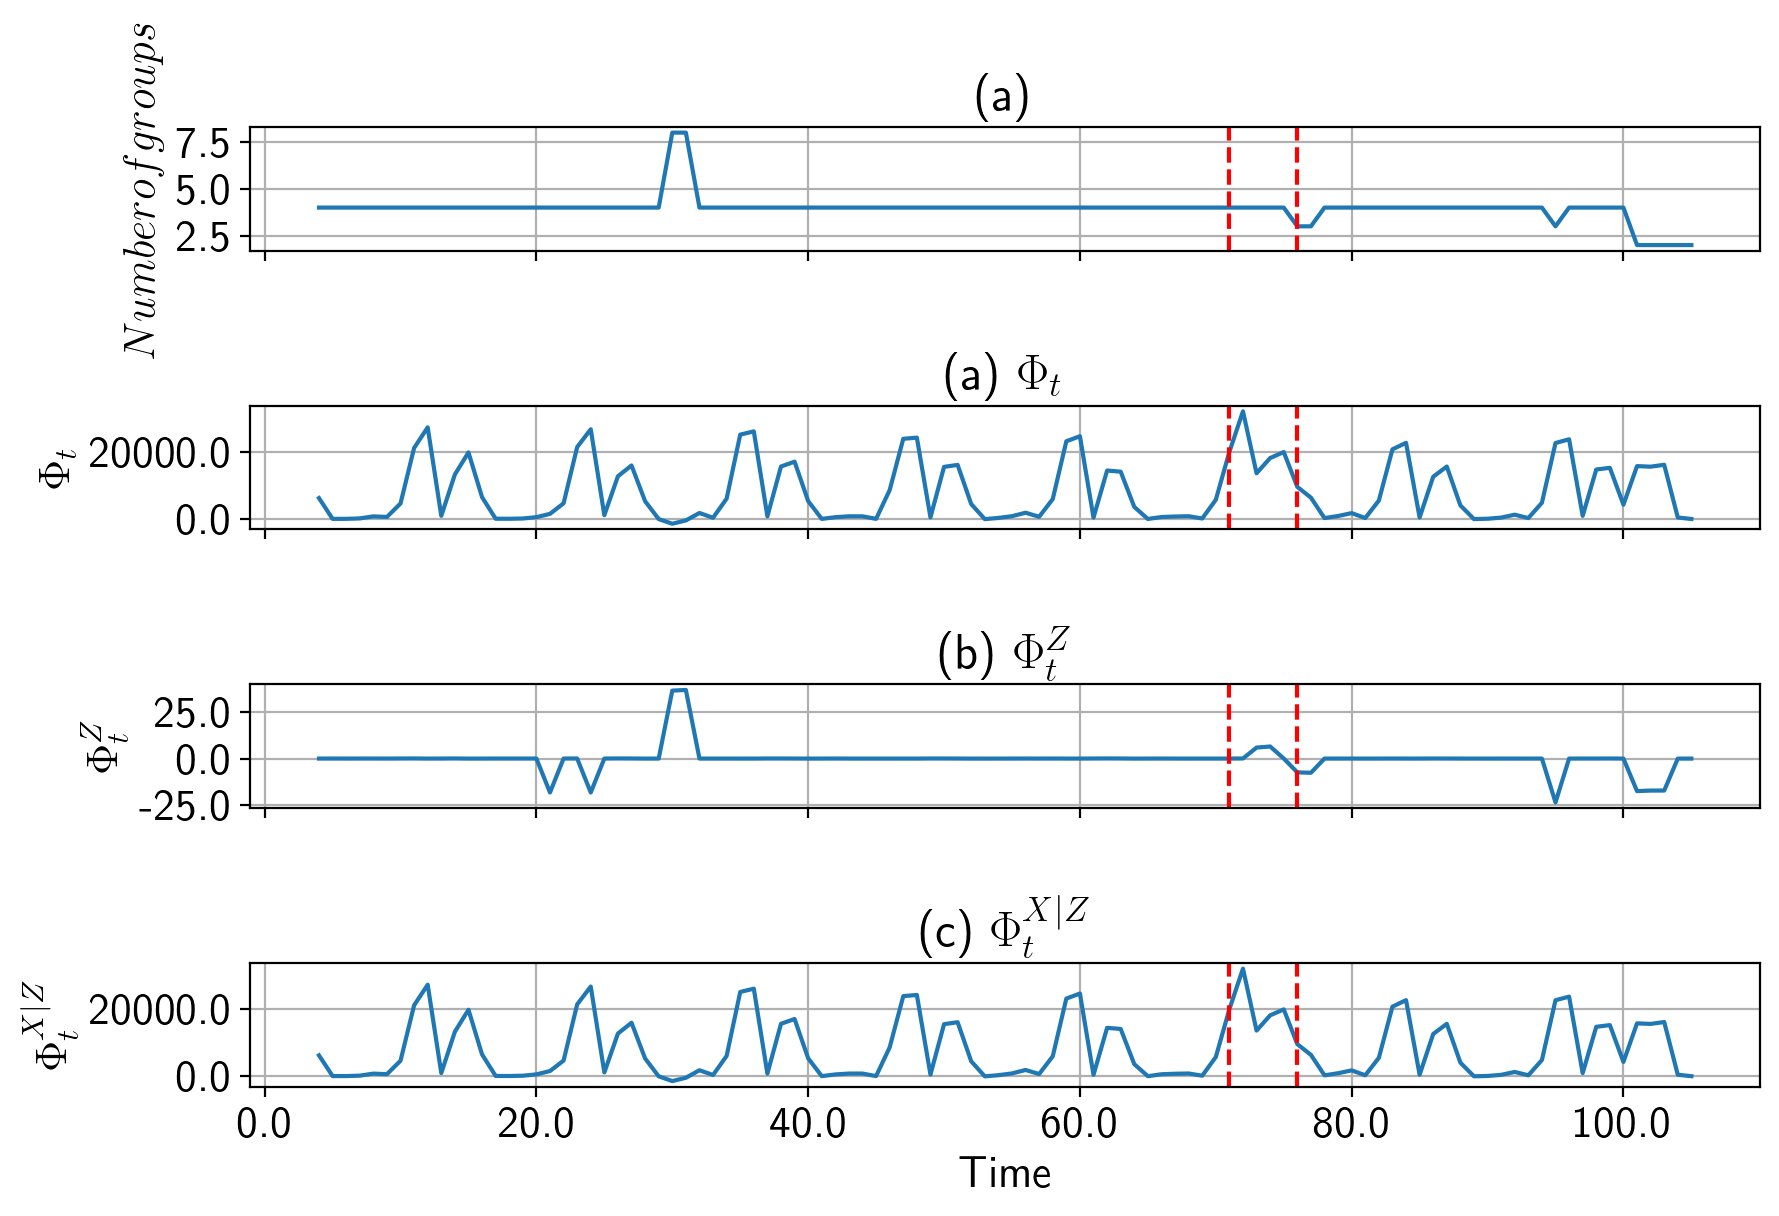

In [40]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(9, 6), dpi=200)

fontsize_title = 18
fontsize = 16

sns.lineplot(x='time', y='value', data=models_estimated_df, ax=axes[0])
axes[0].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[0].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[0].grid()
axes[0].set_title('(a)', fontsize=fontsize_title)
axes[0].set_xlabel('Time', fontsize=fontsize)
axes[0].set_ylabel('$Number of groups$', fontsize=fontsize)
#axes[0].legend(loc='best')


sns.lineplot(x='variable', y='value', data=dnml_df_melt, ax=axes[1])
axes[1].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[1].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[1].grid()
axes[1].set_title(r'(a) $\Phi_{t}$', fontsize=fontsize_title)
axes[1].set_xlabel('Time', fontsize=fontsize)
axes[1].set_ylabel(r'$\Phi_{t}$', fontsize=fontsize)
#axes[1].legend(loc='best')

sns.lineplot(x='variable', y='value', data=nml_z_df_melt, ax=axes[2])
axes[2].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[2].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[2].grid()
axes[2].set_title(r'(b) $\Phi_{t}^{Z}$', fontsize=fontsize_title)
axes[2].set_xlabel('Time', fontsize=fontsize)
axes[2].set_ylabel(r'$\Phi_{t}^{Z}$', fontsize=fontsize)
#axes[2].legend(loc='best')

sns.lineplot(x='variable', y='value', data=nml_x_z_df_melt, ax=axes[3])
axes[3].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[3].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[3].grid()
axes[3].set_title(r'(c) $\Phi_{t}^{X|Z}$', fontsize=fontsize_title)
axes[3].set_xlabel('Time', fontsize=fontsize)
axes[3].set_ylabel(r'$\Phi_{t}^{X|Z}$', fontsize=fontsize)
#axes[3].legend(loc='best')

for ax in axes:
    fontProperties = {'family':'sans-serif', 'weight': 'normal', 'size': 16}
    ax.set_xticklabels(ax.get_xticks(), fontProperties)
    ax.set_yticklabels(ax.get_yticks(), fontProperties)

fig.tight_layout()

plt.show()

In [41]:
print(np.where(ym_list == 2010000101))
print(np.where(ym_list == 2011000101))
print(np.where(ym_list == 2012000101))

(array([57]),)
(array([69]),)
(array([81]),)


In [95]:
import matplotlib

cmap = plt.cm.Reds


N = 14

X = np.array(
     [X_all[57, :N, :][:, :N], X_all[58, :N, :][:, :N], X_all[59, :N, :][:, :N], 
      X_all[60, :N, :][:, :N], X_all[61, :N, :][:, :N], X_all[62, :N, :][:, :N],
      X_all[69, :N, :][:, :N], X_all[70, :N, :][:, :N], X_all[71, :N, :][:, :N], 
      X_all[72, :N, :][:, :N], X_all[73, :N, :][:, :N], X_all[73, :N, :][:, :N],
      X_all[81, :N, :][:, :N], X_all[82, :N, :][:, :N], X_all[83, :N, :][:, :N], 
      X_all[84, :N, :][:, :N], X_all[85, :N, :][:, :N], X_all[86, :N, :][:, :N]])

vmin = np.min(X)
vmax = 2000

fontsize_title = 14
fontsize = 7
fontsize_y = 14

#fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 9), dpi=200)
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(8, 6), dpi=1500)

axes[0, 0].imshow(X_all[59, :N, :][:, :N], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0, 0].set_title('2010-03', fontsize=fontsize_title)
axes[0, 0].set_xticks(np.arange(N))
#axes[0, 0].set_xticklabels(['Hokkaido', 'Aomori', 'Iwate', 'Miyagi', 'Akita', 'Yamagata', 'Fukushima',
#                            'Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Tokyo', 'Kanagawa'], 
#                            #'Niigata', 'Toyama', 'Ishikawa', 'Fukui', 'Yamanashi', 
#                            #'Nagano'], 
#                            rotation=90
#                            )
axes[0, 0].set_yticks(np.arange(N))
axes[0, 0].set_yticklabels(['', '', '', 'Miyagi', '', '', 'Fukushima',
                            '', '', '', '', '', '', ''], 
                            #'Niigata', 'Toyama', 'Ishikawa', 'Fukui', 'Yamanashi', 
                            #'Nagano'], 
                           fontsize=fontsize_y
                          )



axes[0, 1].imshow(X_all[60, :N, :][:, :N], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0, 1].set_title('2010-04', fontsize=fontsize_title)

axes[0, 2].imshow(X_all[61, :N, :][:, :N], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0, 2].set_title('2010-05', fontsize=fontsize_title)

axes[0, 3].imshow(X_all[62, :N, :][:, :N], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0, 3].set_title('2010-06', fontsize=fontsize_title)

axes[1, 0].imshow(X_all[71, :N, :][:, :N], vmin=vmin, vmax=vmax, cmap=cmap)
axes[1, 0].set_title('2011-03', fontsize=fontsize_title)
axes[1, 0].set_yticks(np.arange(N))
axes[1, 0].set_yticklabels(['', '', '', 'Miyagi', '', '', 'Fukushima',
                            '', '', '', '', '', '', ''],
                            #'Niigata', 'Toyama', 'Ishikawa', 'Fukui', 'Yamanashi', 
                            #'Nagano']
                            fontsize=fontsize_y
                            )

axes[1, 1].imshow(X_all[72, :N, :][:, :N], vmin=vmin, vmax=vmax, cmap=cmap)
axes[1, 1].set_title('2011-04', fontsize=fontsize_title)

axes[1, 2].imshow(X_all[73, :N, :][:, :N], vmin=vmin, vmax=vmax, cmap=cmap)
axes[1, 2].set_title('2011-05', fontsize=fontsize_title)

axes[1, 3].imshow(X_all[74, :N, :][:, :N], vmin=vmin, vmax=vmax, cmap=cmap)
axes[1, 3].set_title('2011-06', fontsize=fontsize_title)


axes[2, 0].imshow(X_all[83, :N, :][:, :N], vmin=vmin, vmax=vmax, cmap=cmap)
axes[2, 0].set_title('2012-03', fontsize=fontsize_title)
axes[2, 0].set_xticks(np.arange(N))
axes[2, 0].set_xticklabels(['Hokkaido', 'Aomori', 'Iwate', 'Miyagi', 'Akita', 'Yamagata', 'Fukushima',
                            'Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Tokyo', 'Kanagawa'], rotation=90,
                            fontsize=fontsize
                            #'Niigata', 'Toyama', 'Ishikawa', 'Fukui', 'Yamanashi', 
                            #'Nagano']
                            )
axes[2, 0].set_yticks(np.arange(N))
axes[2, 0].set_yticklabels(['', '', '', 'Miyagi', '', '', 'Fukushima',
                            '', '', '', '', '', '', ''], 
                           fontsize=fontsize_y
                            #'Niigata', 'Toyama', 'Ishikawa', 'Fukui', 'Yamanashi', 
                            #'Nagano']
                          )


axes[2, 1].imshow(X_all[84, :N, :][:, :N], vmin=vmin, vmax=vmax, cmap=cmap)
axes[2, 1].set_title('2012-04', fontsize=fontsize_title)
axes[2, 1].set_xticks(np.arange(N))
axes[2, 1].set_xticklabels(['Hokkaido', 'Aomori', 'Iwate', 'Miyagi', 'Akita', 'Yamagata', 'Fukushima',
                            'Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Tokyo', 'Kanagawa'], rotation=90, 
                            fontsize=fontsize
                            #'Niigata', 'Toyama', 'Ishikawa', 'Fukui', 'Yamanashi', 
                            #'Nagano']
                            )

axes[2, 2].imshow(X_all[85, :N, :][:, :N], vmin=vmin, vmax=vmax, cmap=cmap)
axes[2, 2].set_title('2012-05', fontsize=fontsize_title)
axes[2, 2].set_xticks(np.arange(N))
axes[2, 2].set_xticklabels(['Hokkaido', 'Aomori', 'Iwate', 'Miyagi', 'Akita', 'Yamagata', 'Fukushima',
                            'Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Tokyo', 'Kanagawa'], rotation=90, 
                            fontsize=fontsize
                            #'Niigata', 'Toyama', 'Ishikawa', 'Fukui', 'Yamanashi', 
                            #'Nagano']
                            )

im = axes[2, 3].imshow(X_all[86, :N, :][:, :N], vmin=vmin, vmax=vmax, cmap=cmap)
axes[2, 3].set_title('2012-06', fontsize=fontsize_title)
axes[2, 3].set_xticks(np.arange(N))
axes[2, 3].set_xticklabels(['Hokkaido', 'Aomori', 'Iwate', 'Miyagi', 'Akita', 'Yamagata', 'Fukushima',
                            'Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Tokyo', 'Kanagawa'], rotation=90, 
                            fontsize=fontsize
                            #'Niigata', 'Toyama', 'Ishikawa', 'Fukui', 'Yamanashi', 
                            #'Nagano']
                            )

for i in range(3):
    for j in range(4):
        axes[i, j].axhline(y=2.5, color='blue')
        axes[i, j].axhline(y=3.5, color='blue')

        axes[i, j].axhline(y=5.5, color='green')
        axes[i, j].axhline(y=6.5, color='green')

        
#axes[0, 1].arrow(14, 14, 0, 3, fc='#000000', ec='#000000', head_width=1, head_length=1)

p0 = axes[2, 0].get_position().get_points().flatten()
p1 = axes[2, 3].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.02, p1[2]-p0[0], 0.02])
cbar = fig.colorbar(im, cax=ax_cbar, orientation='horizontal')
#cbar.set_ticklabels([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
cbar.ax.set_xticklabels(['0', '250', '500', '750', '1000', '1250', '1500', '1750', '2000'])
#text = cbar.()
#font = matplotlib.font_manager.FontProperties(family='times new roman', size=16)
#text.set_font_properties(font)


#fig.tight_layout()
plt.subplots_adjust(wspace=-0.2, hspace=0.25)

plt.savefig(os.path.join(outdir, 'heatmap_popmove_hokkaido_kanagawa_2010_2012_03_06.png'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'heatmap_popmove_hokkaido_kanagawa_2010_2012_03_06.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'heatmap_popmove_hokkaido_kanagawa_2010_2012_03_06.eps'), bbox_inches='tight')

In [43]:
import japanmap as jp

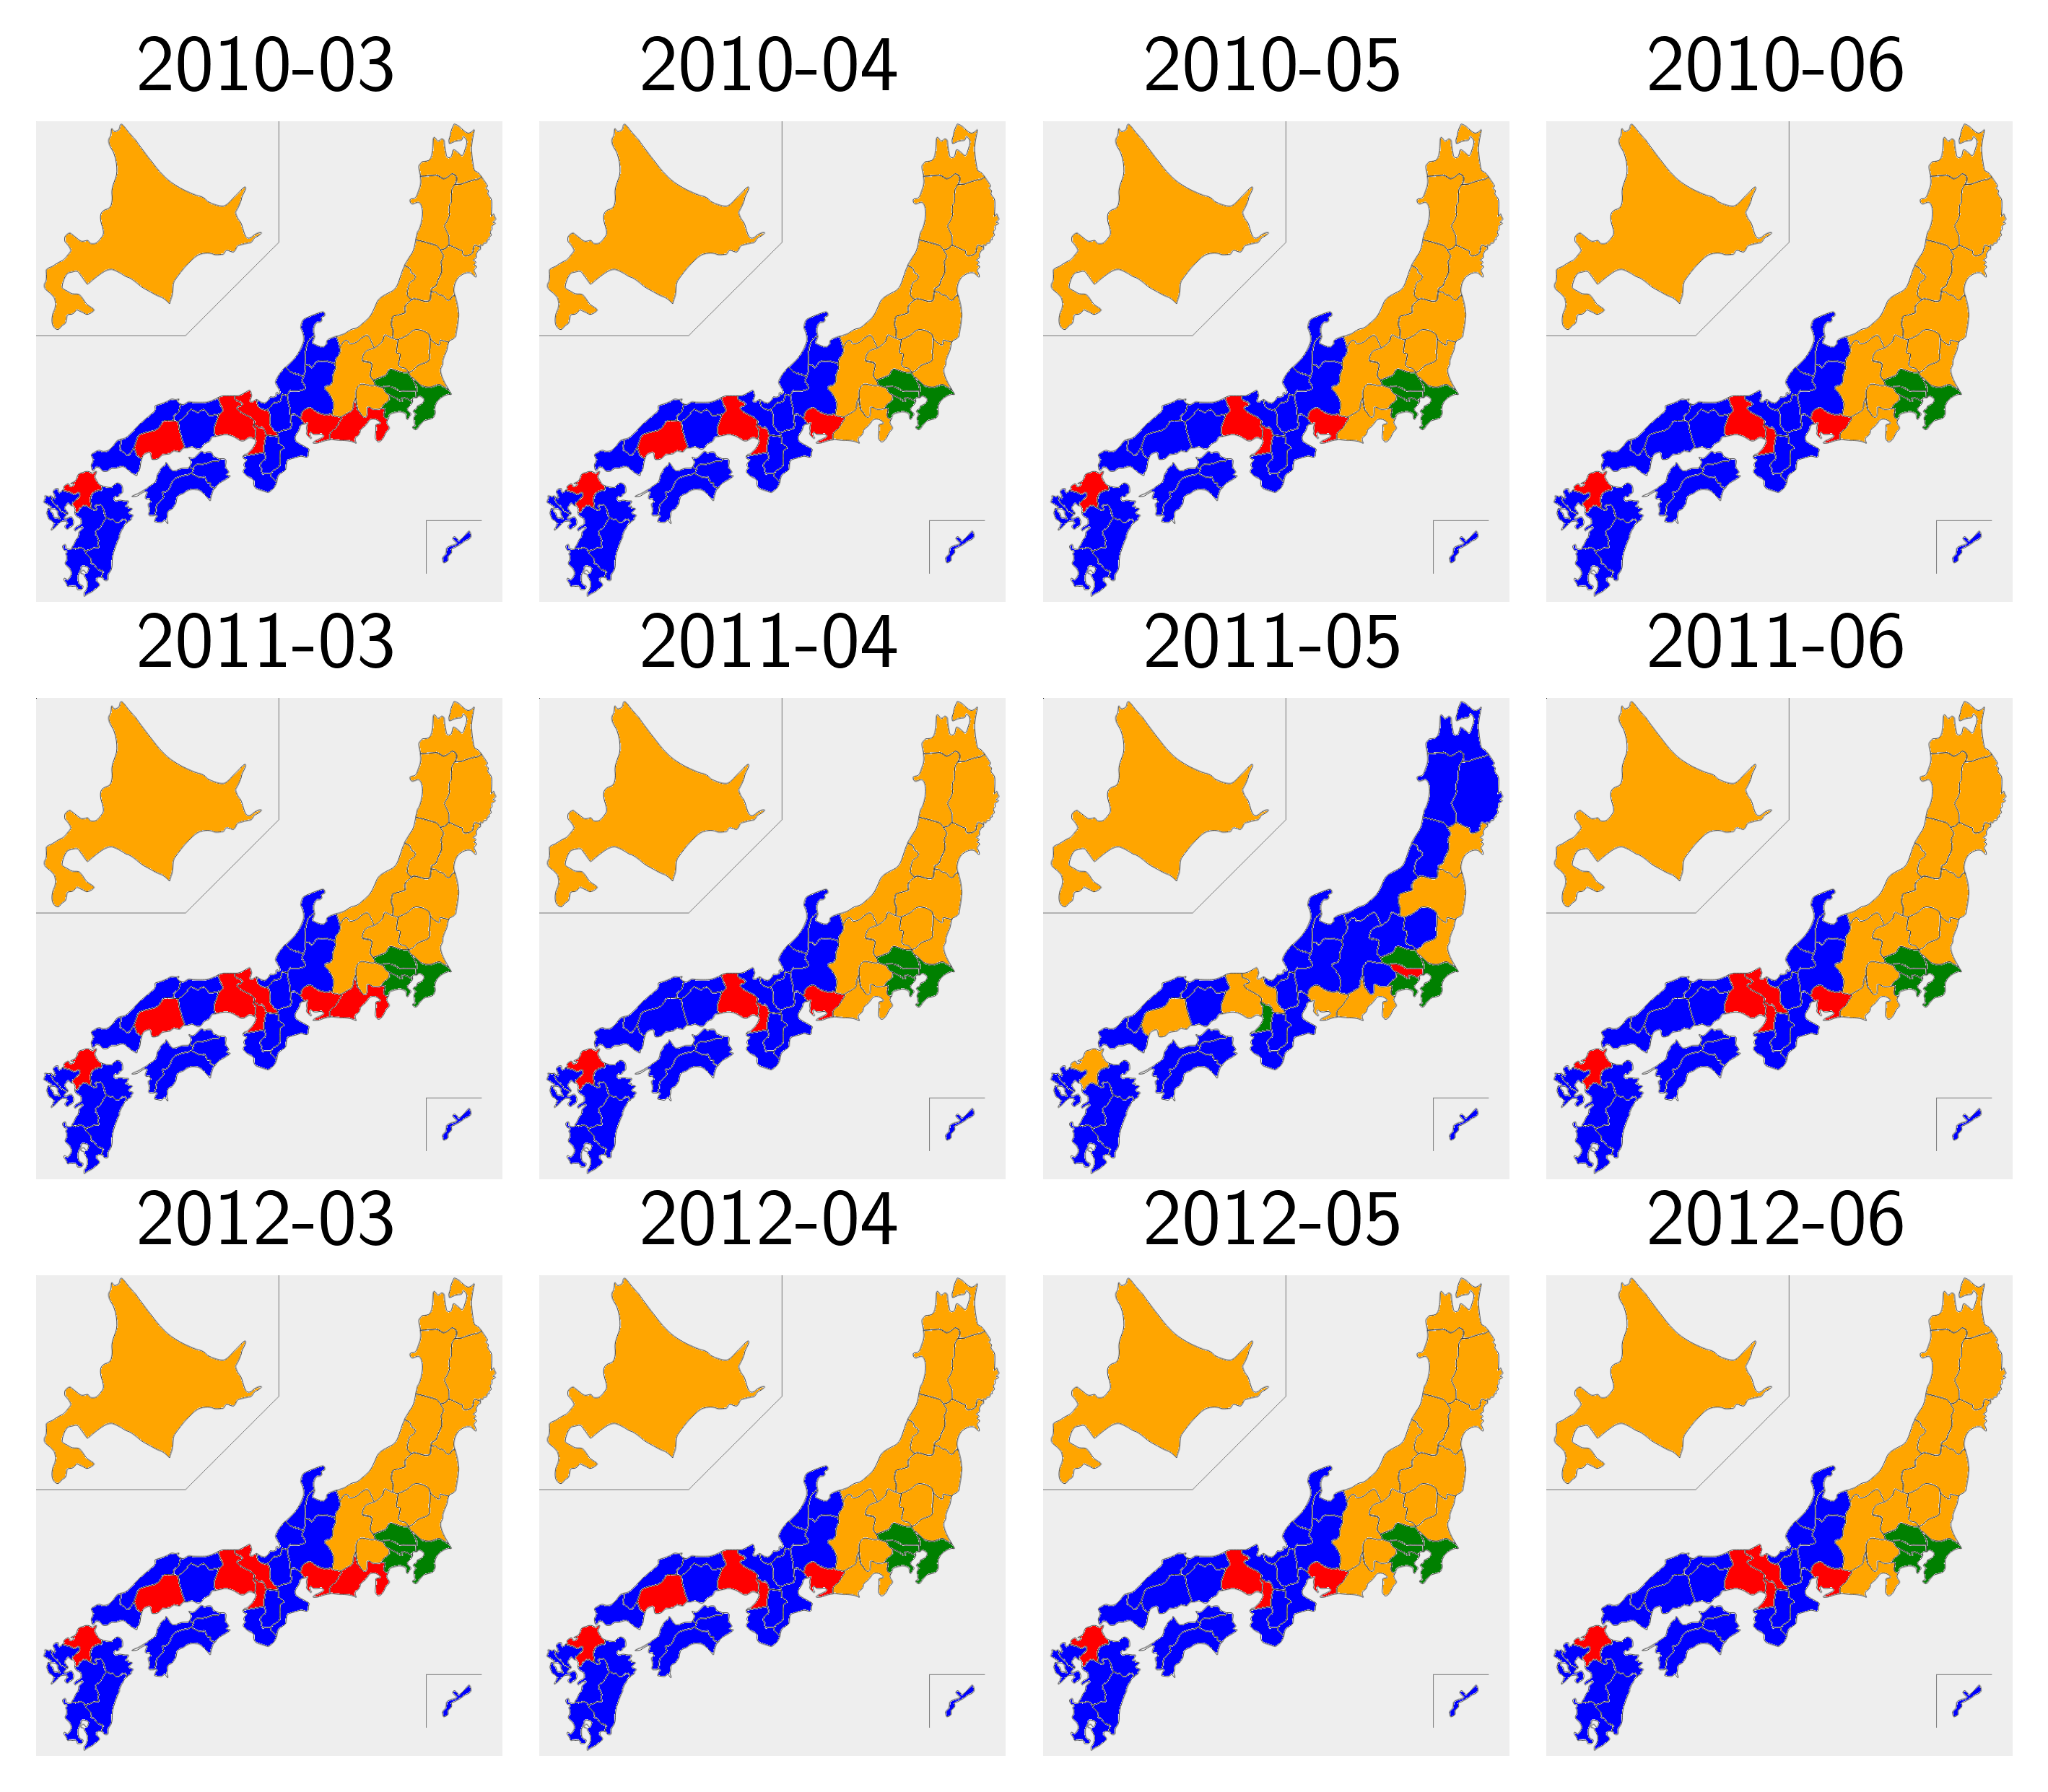

In [73]:
#colors_list = np.array(['blue', 'red', 'green', 'orange'])
colors_list = np.array(['blue', 'green', 'orange', 'red'])
pref_list = jp.pref_names[1:]

fontsize_title = 16

fig, axes = plt.subplots(3, 4, figsize=(9, 6), dpi=500)

# 2010
group_est =np.argmax(Z_all[59][3], axis=1)
axes[0, 0].imshow(jp.picture({name: colors_list[g]  for g, name in zip(group_est, pref_list)}))
axes[0, 0].set_title('2010-03', fontsize=fontsize_title)
axes[0, 0].set_axis_off()

group_est =np.argmax(Z_all[60][3], axis=1)
axes[0, 1].imshow(jp.picture({name: colors_list[g]  for g, name in zip(group_est, pref_list)}))
axes[0, 1].set_title('2010-04', fontsize=fontsize_title)
axes[0, 1].set_axis_off()

group_est =np.argmax(Z_all[61][3], axis=1)
axes[0, 2].imshow(jp.picture({name: colors_list[g]  for g, name in zip(group_est, pref_list)}))
axes[0, 2].set_title('2010-05', fontsize=fontsize_title)
axes[0, 2].set_axis_off()

group_est =np.argmax(Z_all[62][3], axis=1)
axes[0, 3].imshow(jp.picture({name: colors_list[g]  for g, name in zip(group_est, pref_list)}))
axes[0, 3].set_title('2010-06', fontsize=fontsize_title)
axes[0, 3].set_axis_off()



# 2011
group_est =np.argmax(Z_all[71][3], axis=1)
axes[1, 0].imshow(jp.picture({name: colors_list[g]  for g, name in zip(group_est, pref_list)}))
axes[1, 0].set_title('2011-03', fontsize=fontsize_title)
axes[1, 0].set_axis_off()

group_est =np.argmax(Z_all[72][3], axis=1)
axes[1, 1].imshow(jp.picture({name: colors_list[g]  for g, name in zip(group_est, pref_list)}))
axes[1, 1].set_title('2011-04', fontsize=fontsize_title)
axes[1, 1].set_axis_off()

group_est =np.argmax(Z_all[73][3], axis=1)
axes[1, 2].imshow(jp.picture({name: colors_list[g]  for g, name in zip(group_est, pref_list)}))
axes[1, 2].set_title('2011-05', fontsize=fontsize_title)
axes[1, 2].set_axis_off()

group_est =np.argmax(Z_all[74][3], axis=1)
axes[1, 3].imshow(jp.picture({name: colors_list[g]  for g, name in zip(group_est, pref_list)}))
axes[1, 3].set_title('2011-06', fontsize=fontsize_title)
axes[1, 3].set_axis_off()

# 2012
group_est =np.argmax(Z_all[83][3], axis=1)
axes[2, 0].imshow(jp.picture({name: colors_list[g]  for g, name in zip(group_est, pref_list)}))
axes[2, 0].set_title('2012-03', fontsize=fontsize_title)
axes[2, 0].set_axis_off()

group_est =np.argmax(Z_all[84][3], axis=1)
axes[2, 1].imshow(jp.picture({name: colors_list[g]  for g, name in zip(group_est, pref_list)}))
axes[2, 1].set_title('2012-04', fontsize=fontsize_title)
axes[2, 1].set_axis_off()

group_est =np.argmax(Z_all[85][3], axis=1)
axes[2, 2].imshow(jp.picture({name: colors_list[g]  for g, name in zip(group_est, pref_list)}))
axes[2, 2].set_title('2012-05', fontsize=fontsize_title)
axes[2, 2].set_axis_off()

group_est =np.argmax(Z_all[86][3], axis=1)
axes[2, 3].imshow(jp.picture({name: colors_list[g]  for g, name in zip(group_est, pref_list)}))
axes[2, 3].set_title('2012-06', fontsize=fontsize_title)
axes[2, 3].set_axis_off()

#fig.tight_layout()
plt.subplots_adjust(wspace=-0.5, hspace=0.2)
#plt.show()

plt.savefig(os.path.join(outdir, 'plot_pref_groups_2011_2013_03_06.eps'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'plot_pref_groups_2011_2013_03_06.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'plot_pref_groups_2011_2013_03_06.png'), bbox_inches='tight')

# Deltacon

In [45]:
outdir_deltacon = './output/deltacon'
if not os.path.exists(outdir_deltacon):
    os.makedirs(outdir_deltacon)

In [46]:
octave.addpath('./deltacon')

'.:/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/oct2py:/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/octave_kernel:/usr/local/Cellar/octave/5.2.0_9/share/octave/site/m:/usr/local/Cellar/octave/5.2.0_9/share/octave/site/m/startup:/usr/local/Cellar/octave/5.2.0_9/lib/octave/5.2.0/oct/x86_64-apple-darwin18.7.0:/usr/local/Cellar/octave/5.2.0_9/share/octave/5.2.0/m:/usr/local/Cellar/octave/5.2.0_9/share/octave/5.2.0/m/audio:/usr/local/Cellar/octave/5.2.0_9/share/octave/5.2.0/m/deprecated:/usr/local/Cellar/octave/5.2.0_9/share/octave/5.2.0/m/elfun:/usr/local/Cellar/octave/5.2.0_9/share/octave/5.2.0/m/general:/usr/local/Cellar/octave/5.2.0_9/share/octave/5.2.0/m/geometry:/usr/local/Cellar/octave/5.2.0_9/share/octave/5.2.0/m/gui:/usr/local/Cellar/octave/5.2.0_9/share/octave/5.2.0/m/help:/usr/local/Cellar/octave/5.2.0_9/share/octave/5.2.0/m/image:/usr/local/Cellar/octave/5.2.0_9/share/octave/5.2.0/m/io:/usr/local/Cellar/octa

In [47]:
"""
for t in tqdm.tqdm(range(X_all.shape[0])):
    idxes_i, idxes_j = np.where(X_all[t, :, :] == 1)
    res = np.hstack((idxes_i.reshape(-1, 1) + 1, 
                     idxes_j.reshape(-1, 1) + 1, 
                     np.ones((len(idxes_i), 1), dtype=np.int)
                    )
                   ).astype(np.int)
    fname = os.path.join(outdir, 'edgelist_%03d.txt' % (t))
    np.savetxt(fname, res, fmt='%i')
"""

"\nfor t in tqdm.tqdm(range(X_all.shape[0])):\n    idxes_i, idxes_j = np.where(X_all[t, :, :] == 1)\n    res = np.hstack((idxes_i.reshape(-1, 1) + 1, \n                     idxes_j.reshape(-1, 1) + 1, \n                     np.ones((len(idxes_i), 1), dtype=np.int)\n                    )\n                   ).astype(np.int)\n    fname = os.path.join(outdir, 'edgelist_%03d.txt' % (t))\n    np.savetxt(fname, res, fmt='%i')\n"

In [48]:
X_all.shape

(108, 47, 47)

In [49]:
n_time = X_all.shape[0]

scores_deltacon = [np.nan]
idxes_list = [os.path.join(outdir_deltacon, 'edgelist_%03d.txt' % (t)) for t in range(n_time)]

for t in range(1, n_time):
    edgelist_prev = idxes_list[t-1]
    edgelist_cur = idxes_list[t]
    score_t = octave.feval('DeltaCon', 'edge', 'naive', edgelist_prev, edgelist_cur, 0.1)
    scores_deltacon.append(score_t)

scores_deltacon = np.array(scores_deltacon)
    
df_scores_deltacon = pd.DataFrame({'time': np.arange(1, n_time+1),
                          'score': scores_deltacon,
                          'dissim': (1.0 - scores_deltacon)}, 
                          columns=['time', 'score', 'dissim'])

# Ide and Kashima

In [50]:
I = np.ones((47, 47))
np.fill_diagonal(I, 0)

In [51]:
I = np.ones((X_all.shape[1], X_all.shape[1]))
np.fill_diagonal(I, 0.0)

alpha = 0.01
d = np.array([(X_all[t, :, :] + X_all[t, :, :].T) * I +  alpha * I for t in range(X_all.shape[0])])

T = d.shape[0]
u_array = np.array([np.linalg.svd(d[t, :, :])[1] / np.sqrt(np.sum(np.linalg.svd(d[t, :, :])[1]**2)) for t in range(T)])

In [52]:
u_array.shape

(108, 47)

In [53]:
D = d.shape[1]
r_disc = 0.1
r_init = np.random.uniform(0, 1, D)
r_init /= np.sqrt(np.sum(r_init**2))
r_tilde = r_init.copy()

r_tilde_array = np.nan * np.ones((T, D))

for t in range(1, T):
    r_tilde = u_array[t, :] + (1 -r_disc) *r_tilde
    r_tilde_array[t, :] = r_tilde
    
for t in range(1, T):
    r_tilde = u_array[t, :] + (1 -r_disc) *r_tilde
    r_tilde_array[t, :] = r_tilde

In [54]:
r_tilde_array

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [7.70504898e+00, 5.34106723e+00, 1.98737345e+00, ...,
        1.29240020e-02, 8.27639059e-03, 2.84757687e-03],
       [7.69764962e+00, 5.33750520e+00, 2.00802705e+00, ...,
        1.24573282e-02, 8.24237979e-03, 2.68687017e-03],
       ...,
       [7.67805179e+00, 5.41993401e+00, 1.96269650e+00, ...,
        1.19538233e-02, 8.26955435e-03, 2.79425461e-03],
       [7.66740010e+00, 5.43867555e+00, 1.97024951e+00, ...,
        1.15260008e-02, 7.76181824e-03, 2.73298316e-03],
       [7.70319039e+00, 5.36280683e+00, 1.96739913e+00, ...,
        1.30811216e-02, 8.28870130e-03, 2.56644406e-03]])

In [55]:
r_estimated_array = r_tilde_array / np.sqrt(np.nansum(r_tilde_array**2, axis=1).reshape(-1, 1))

In [56]:
r_estimated_array.shape

(108, 47)

In [57]:
u_array.shape

(108, 47)

In [58]:
scores_eigenspace = 1.0 - np.nansum(r_estimated_array * u_array, axis=1)

In [59]:
df_scores_eigenspace = pd.DataFrame({'time': np.arange(1, n_time+1),
                          'score': scores_eigenspace}, 
                          columns=['time', 'score'])

<>:15: DeprecationWarning: invalid escape sequence \#
<>:15: DeprecationWarning: invalid escape sequence \#
<>:15: DeprecationWarning: invalid escape sequence \#
<ipython-input-96-c1712fbf08fe>:15: DeprecationWarning: invalid escape sequence \#
  axes[0].set_title('(a) \#Blocks', fontsize=fontsize_title)


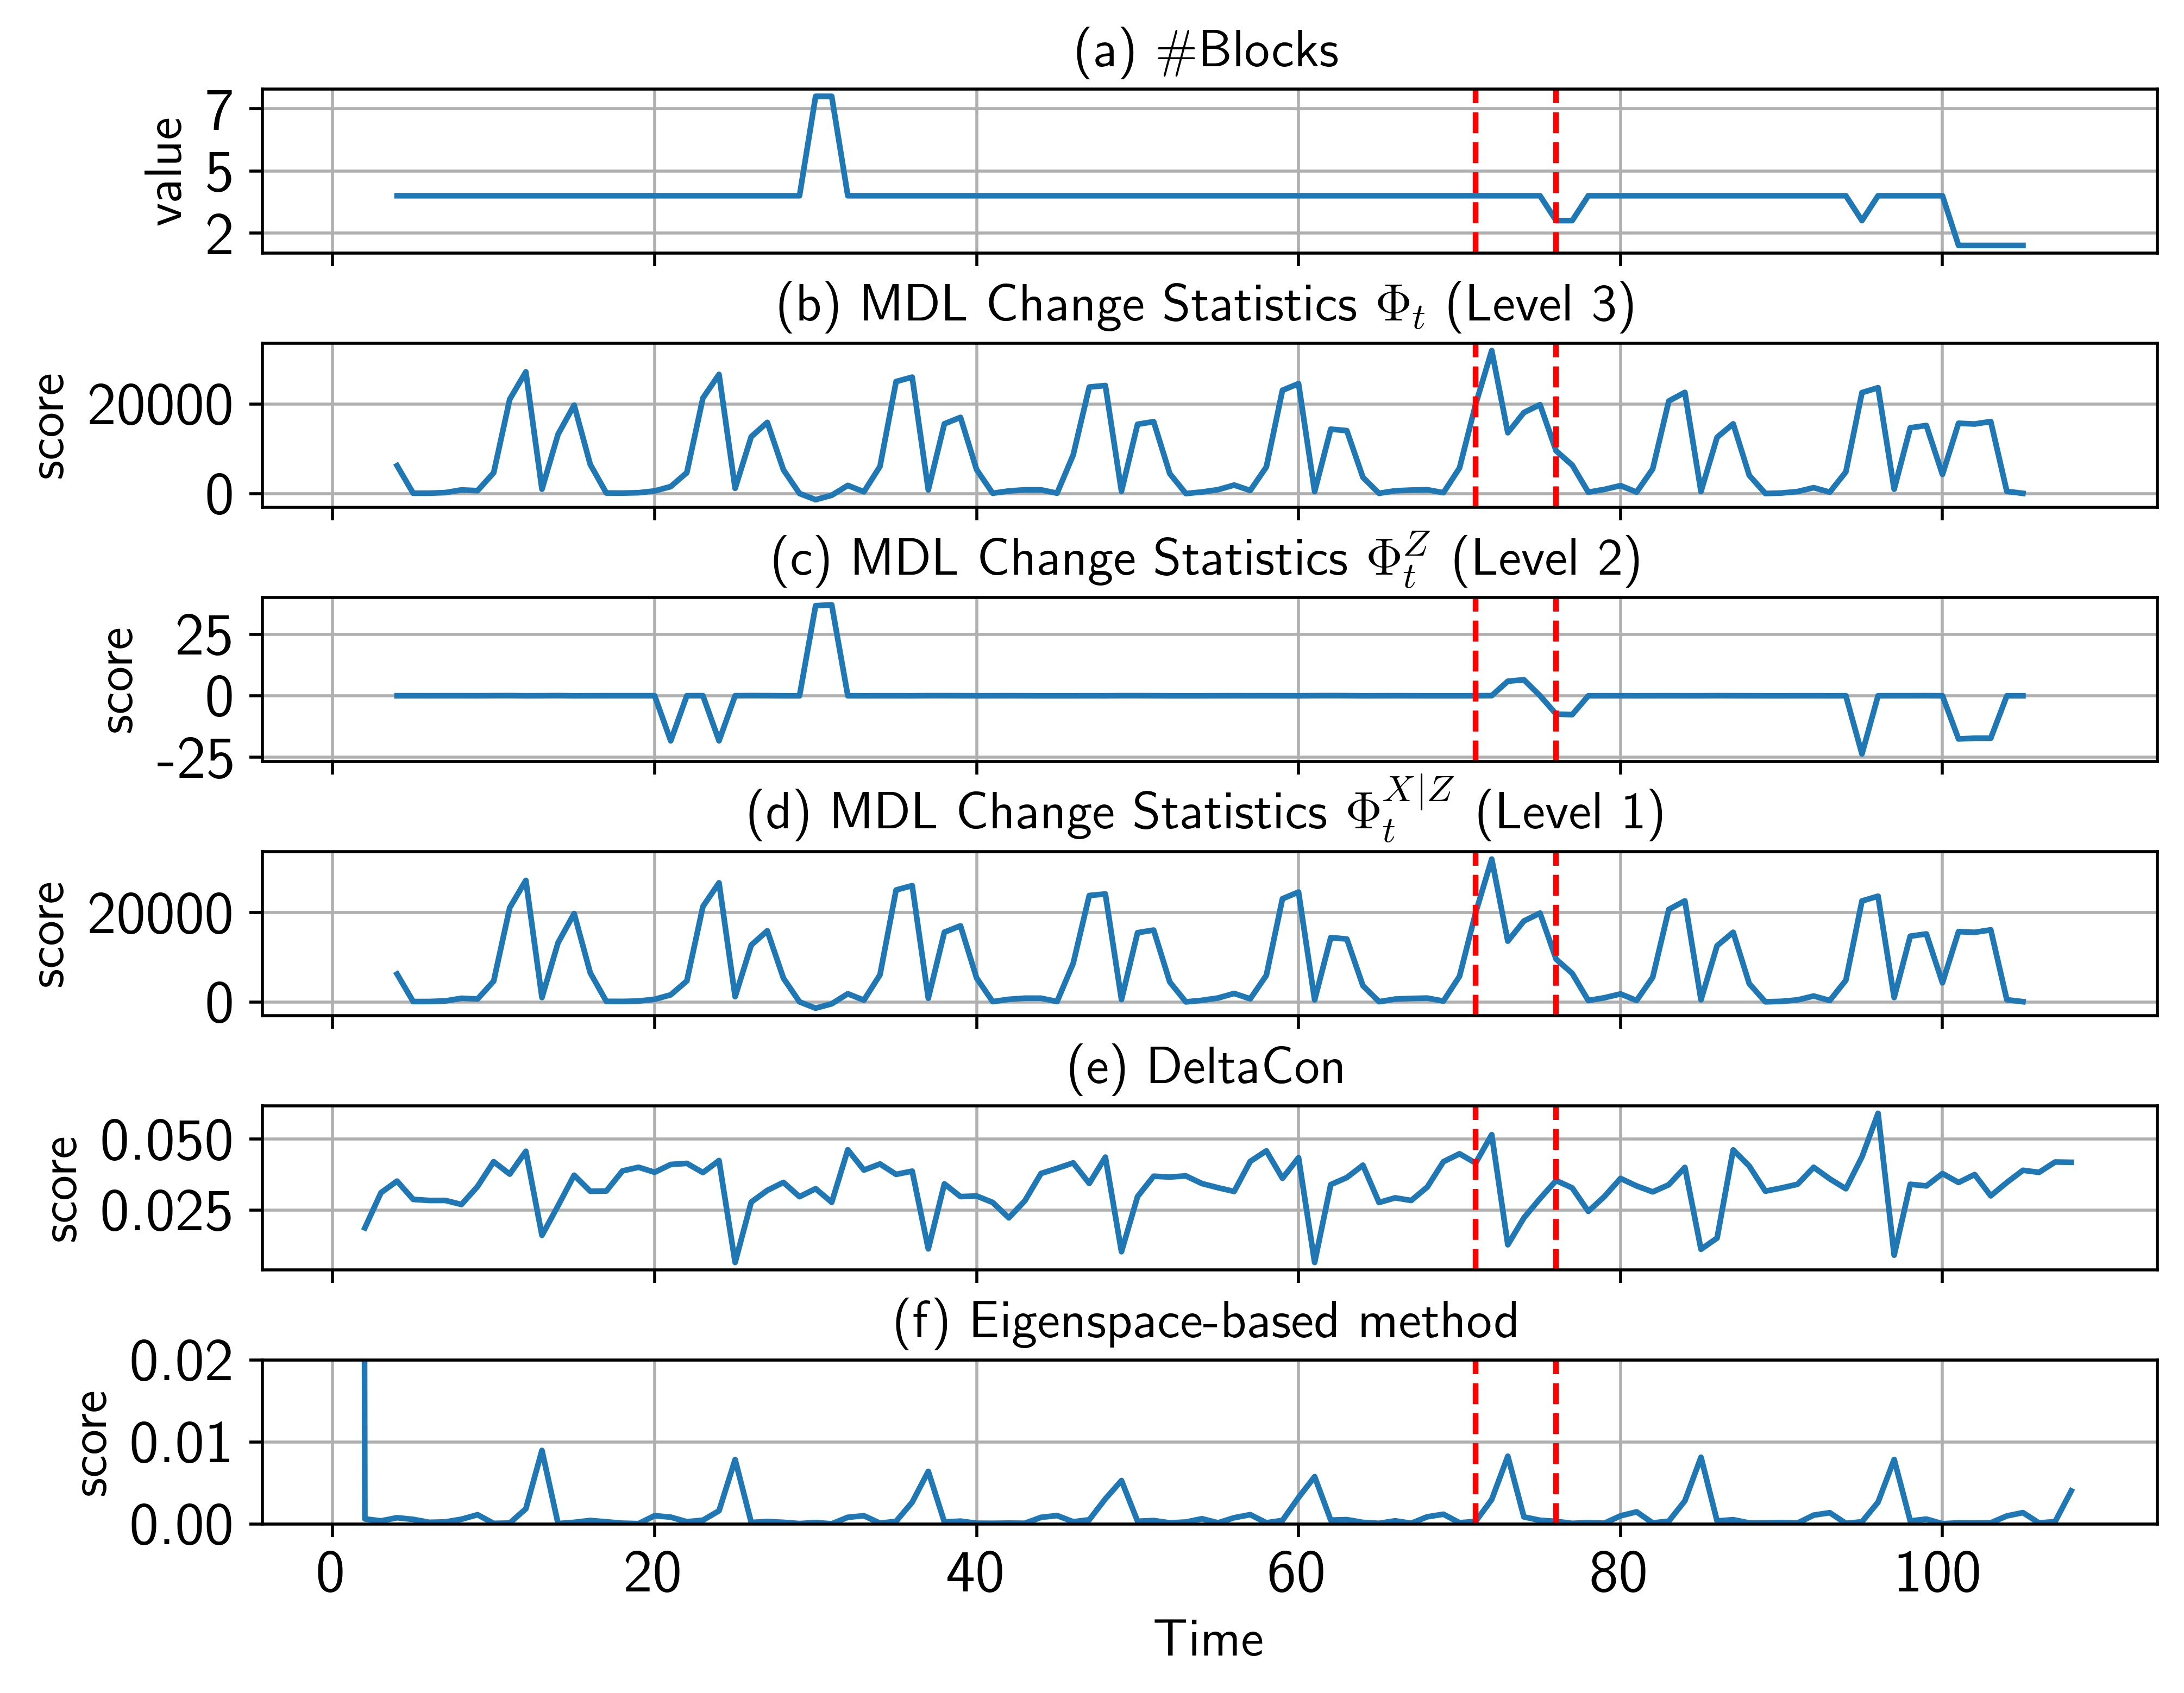

In [96]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

#fontsize_title = 20
#fontsize = 18
fontsize_title = 14
fontsize = 14

fig, axes = plt.subplots(6, 1, sharex=True, figsize=(9, 7), dpi=500)

sns.lineplot(x='time', y='value', data=models_estimated_df, ax=axes[0])
axes[0].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[0].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[0].grid()
axes[0].set_title('(a) \#Blocks', fontsize=fontsize_title)
axes[0].set_xlabel('Time', fontsize=fontsize)
axes[0].set_ylabel('value', fontsize=fontsize)

sns.lineplot(x='variable', y='value', data=dnml_df_melt, ax=axes[1])
axes[1].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[1].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[1].grid()
axes[1].set_title(r'(b) MDL Change Statistics $\Phi_{t}$ (Level 3)', fontsize=fontsize_title)
axes[1].set_xlabel('Time', fontsize=fontsize)
axes[1].set_ylabel('score', fontsize=fontsize)
#axes[0].legend(loc='best')

sns.lineplot(x='variable', y='value', data=nml_z_df_melt, ax=axes[2])
axes[2].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[2].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[2].grid()
axes[2].set_title(r'(c) MDL Change Statistics $\Phi_{t}^{Z}$ (Level 2)', fontsize=fontsize_title)
axes[2].set_xlabel('Time', fontsize=fontsize)
axes[2].set_ylabel('score', fontsize=fontsize)

sns.lineplot(x='variable', y='value', data=nml_x_z_df_melt, ax=axes[3])
axes[3].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[3].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[3].grid()
axes[3].set_title(r'(d) MDL Change Statistics $\Phi_{t}^{X|Z}$ (Level 1)', fontsize=fontsize_title)
axes[3].set_xlabel('Time', fontsize=fontsize)
axes[3].set_ylabel('score', fontsize=fontsize)

sns.lineplot(x='time', y='dissim', data=df_scores_deltacon, ax=axes[4])
axes[4].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[4].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[4].grid()
axes[4].set_title('(e) DeltaCon', fontsize=fontsize_title)
axes[4].set_xlabel('Time', fontsize=fontsize)
axes[4].set_ylabel('score', fontsize=fontsize)

sns.lineplot(x='time', y='score', data=df_scores_eigenspace, ax=axes[5])
axes[5].set_ylim(0, 0.02)
axes[5].axvline(x=idx_201103, linestyle='dashed', color='red')
axes[5].axvline(x=idx_201108, linestyle='dashed', color='red')
axes[5].grid()
axes[5].set_title('(f) Eigenspace-based method', fontsize=fontsize_title)
axes[5].set_xlabel('Time', fontsize=fontsize)
#axes[5].set_ylabel('score (NML)', fontsize=fontsize)
axes[5].set_ylabel('score', fontsize=fontsize)


for i, ax in enumerate(axes):
    fontProperties = {'family':'sans-serif', 'weight': 'normal', 'size': 16}
    ax.set_xticklabels(ax.get_xticks(), fontProperties)
    ax.set_yticklabels(ax.get_yticks(), fontProperties)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    if (i !=4) & (i !=5):
        ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    elif (i==4):
        #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    else:
        #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#fig.tight_layout()
#plt.show()

plt.subplots_adjust(hspace=0.55)

plt.savefig(os.path.join(outdir, 'plot_estimated_score_nblocks_popmove_h3.eps'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'plot_estimated_score_nblocks_popmove_h3.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'plot_estimated_score_nblocks_popmove_h3.png'), bbox_inches='tight')